In [13]:
from pyspark.sql.functions import (
    col, count, desc, explode, ceil, unix_timestamp, window, sum, when, array_contains, lit, split
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1715130545371_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1715130545371_0002,pyspark,idle,Link,Link,None,✔


In [7]:
sc.install_pypi_package("pandas")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt/yarn/usercache/livy/appcache/application_1715130545371_0002/container_1715130545371_0002_01_000001/tmp/spark-77542181-fec3-477f-b196-a420a772de09
    Can't uninstall 'python-dateutil'. No files were found to uninstall.


In [8]:
sc.install_pypi_package("matplotlib")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
import matplotlib.pyplot as plt

# path to specific S3 location where the data is sitting

posts_path = 's3://samplebucketbig/output_parquet_file/'

posts_all = spark.read.parquet(posts_path)

posts_all.printSchema()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- id: long (nullable = true)
 |-- creation_date: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- body: string (nullable = true)
 |-- comments: long (nullable = true)
 |-- accepted_answer_id: long (nullable = true)
 |-- answers: long (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- owner_display_name: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- parent_id: long (nullable = true)
 |-- post_type_id: long (nullable = true)
 |-- score: long (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: long (nullable = true)

In [10]:
# select only cols we will work with and cache it

posts = posts_all.select(
    'id',
    'post_type_id',
    'accepted_answer_id',
    'user_id',
    'creation_date',
    'tags'
).cache()

# Compute the Posts count
posts.count()




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

59819048

In [14]:
# Questions and Answers Count
questions = posts.filter(col('post_type_id') == 1)
answers = posts.filter(col('post_type_id') == 2)

questions.count()



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

24101803

In [15]:
answers.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

35603624

In [27]:
# questions with accepted answer

accepted = questions.filter(col('accepted_answer_id').isNotNull())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
accepted.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12260106

In [17]:
# distinct number of users:

posts.filter(col('user_id').isNotNull()).select('user_id').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

6281053

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

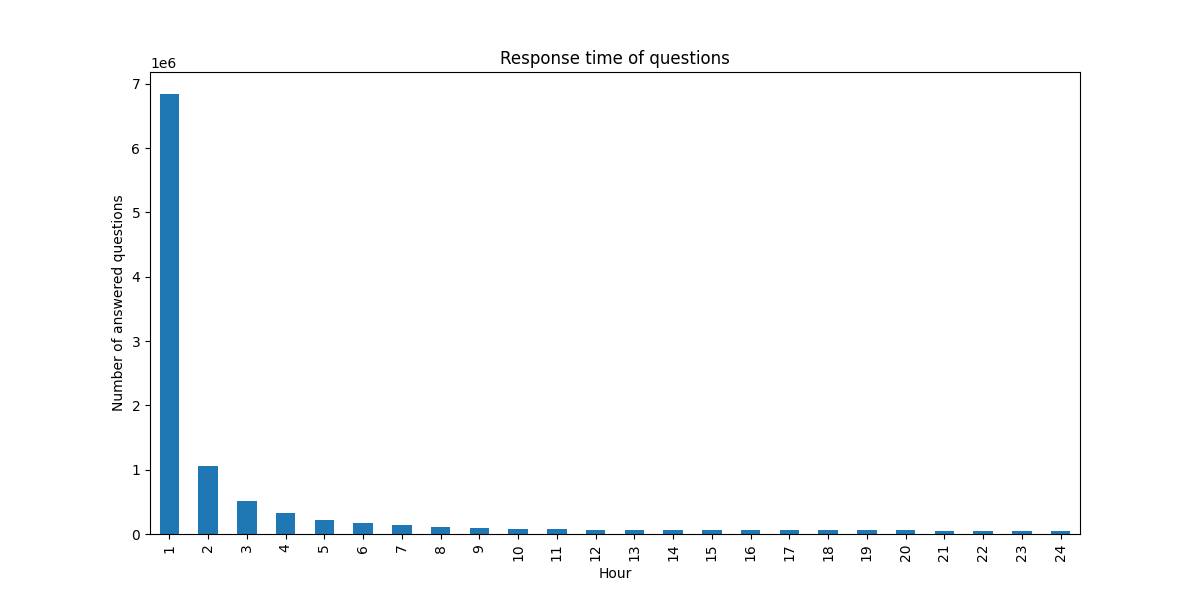

In [18]:
# Computing the response time
response_time = (
    questions.alias('questions')
    .join(answers.alias('answers'), col('questions.accepted_answer_id') == col('answers.id'))
    .select(
        col('questions.id'),
        col('questions.creation_date').alias('question_time'),
        col('answers.creation_date').alias('answer_time')
    )
    .withColumn('response_time', unix_timestamp('answer_time') - unix_timestamp('question_time'))
    .filter(col('response_time') > 0)
    .orderBy('response_time')
)

response_time.show(n=5)

hourly_data = (
    response_time
    .withColumn('hours', ceil(col('response_time') / 3600))
    .groupBy('hours')
    .agg(count('*').alias('cnt'))
    .orderBy('hours')
    .limit(24)
).toPandas()

# See the number of questions answered within each hour
hourly_data.plot(
    x='hours', y='cnt', figsize=(12, 6), 
    title='Response time of questions',
    legend=False,
    kind='bar',
    xlabel='Hour',
    ylabel='Number of answered questions'
)

%matplot plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

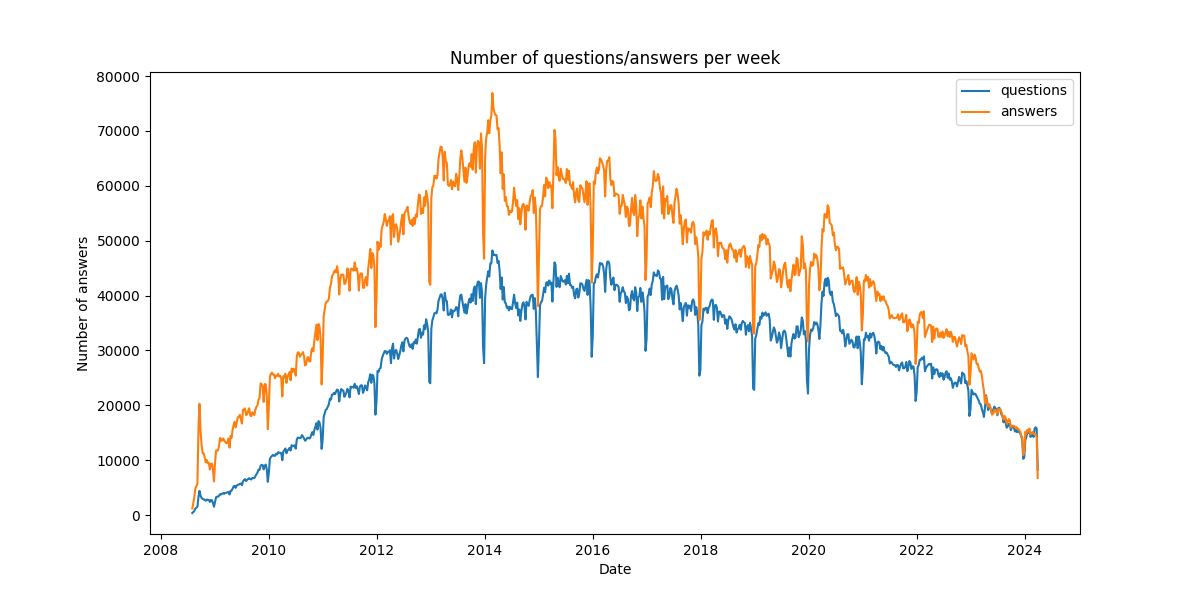

In [19]:
# See the time evolution of the number of questions and answeres
posts_grouped = (
    posts
    .filter(col('user_id').isNotNull())
    .groupBy(
        window('creation_date', '1 week')
    )
    .agg(
        sum(when(col('post_type_id') == 1, lit(1)).otherwise(lit(0))).alias('questions'),
        sum(when(col('post_type_id') == 2, lit(1)).otherwise(lit(0))).alias('answers')
    )
    .withColumn('date', col('window.start').cast('date'))
    .orderBy('date')
).toPandas()

posts_grouped.plot(
    x='date', 
    figsize=(12, 6), 
    title='Number of questions/answers per week',
    legend=True,
    xlabel='Date',
    ylabel='Number of answers',
    kind='line'
)

%matplot plt


In [20]:
# Compute number of tags
(
    questions
    .withColumn('tags', split('tags', '><'))
    .selectExpr(
        '*',
        "TRANSFORM(tags, value -> regexp_replace(value, '(>|<)', '')) AS tags_arr"
    )
    .withColumn('tag', explode('tags_arr'))
    .select('tag')
    .distinct()
).count()

# See most popular tags
(
    questions
    .withColumn('tags', split('tags', '><'))
    .selectExpr(
        '*',
        "TRANSFORM(tags, value -> regexp_replace(value, '(>|<)', '')) AS tags_arr"
    )
    .withColumn('tag', explode('tags_arr'))
    .groupBy('tag')
    .agg(count('*').alias('tag_frequency'))
    .orderBy(desc('tag_frequency'))
).show(n=10)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------+
|                tag|tag_frequency|
+-------------------+-------------+
|           |python||       139664|
|       |javascript||       138221|
|          |android||       114177|
|         |html|css||       110312|
|             |java||       109020|
||javascript|jquery||        96439|
|              |php||        95984|
|                |r||        77063|
|               |c#||        75442|
|              |c++||        73109|
+-------------------+-------------+
only showing top 10 rows

In [22]:
posts.unpersist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[id: bigint, post_type_id: bigint, accepted_answer_id: bigint, user_id: bigint, creation_date: timestamp, tags: string]

In [23]:
response_time = (
    questions.alias('questions')
    .join(answers.alias('answers'), col('questions.accepted_answer_id') == col('answers.id'))
    .select(
        col('questions.id'),
        col('questions.creation_date').alias('question_time'),
        col('answers.creation_date').alias('answer_time')
    )
    .withColumn('response_time', unix_timestamp('answer_time') - unix_timestamp('question_time'))
    .filter(col('response_time') > 0)
    .orderBy('response_time')
)

response_time.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-----------------------+-----------------------+-------------+
|id      |question_time          |answer_time            |response_time|
+--------+-----------------------+-----------------------+-------------+
|10882860|2012-06-04 14:17:36.423|2012-06-04 14:17:37.033|1            |
|10779149|2012-05-28 03:50:05.98 |2012-05-28 03:50:06.2  |1            |
|11065082|2012-06-16 16:14:35.817|2012-06-16 16:14:36.657|1            |
|10856844|2012-06-01 20:20:57.87 |2012-06-01 20:20:58.323|1            |
|10898097|2012-06-05 13:20:45.717|2012-06-05 13:20:46.03 |1            |
|11300711|2012-07-02 20:29:00.537|2012-07-02 20:29:01.317|1            |
|11011995|2012-06-13 09:30:47.5  |2012-06-13 09:30:48.03 |1            |
|11148567|2012-06-22 00:05:01.737|2012-06-22 00:05:02.203|1            |
|10746890|2012-05-25 00:02:07.927|2012-05-25 00:02:08.083|1            |
|11030197|2012-06-14 09:25:33.97 |2012-06-14 09:25:34.313|1            |
|10923558|2012-06-06 23:08:36.723|2012-06-06 23:08:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

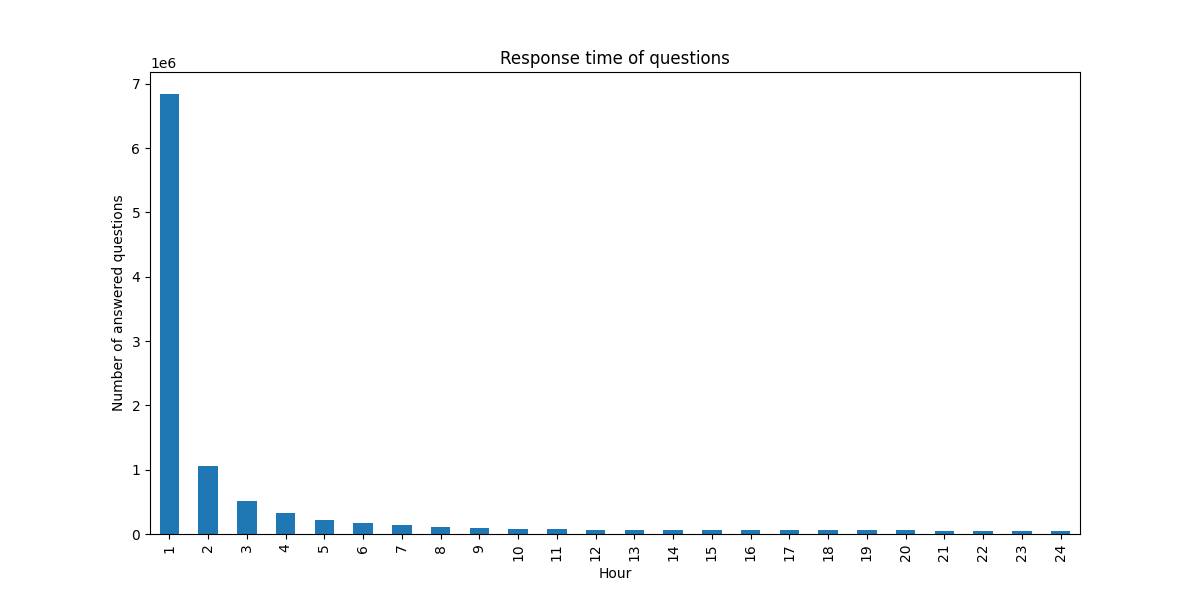

In [24]:
hourly_data = (
    response_time
    .withColumn('hours', ceil(col('response_time') / 3600))
    .groupBy('hours')
    .agg(count('*').alias('cnt'))
    .orderBy('hours')
    .limit(24)
).toPandas()

hourly_data.plot(
    x='hours', y='cnt', figsize=(12, 6), 
    title='Response time of questions',
    legend=False,
    kind='bar',
    xlabel='Hour',
    ylabel='Number of answered questions'
)

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

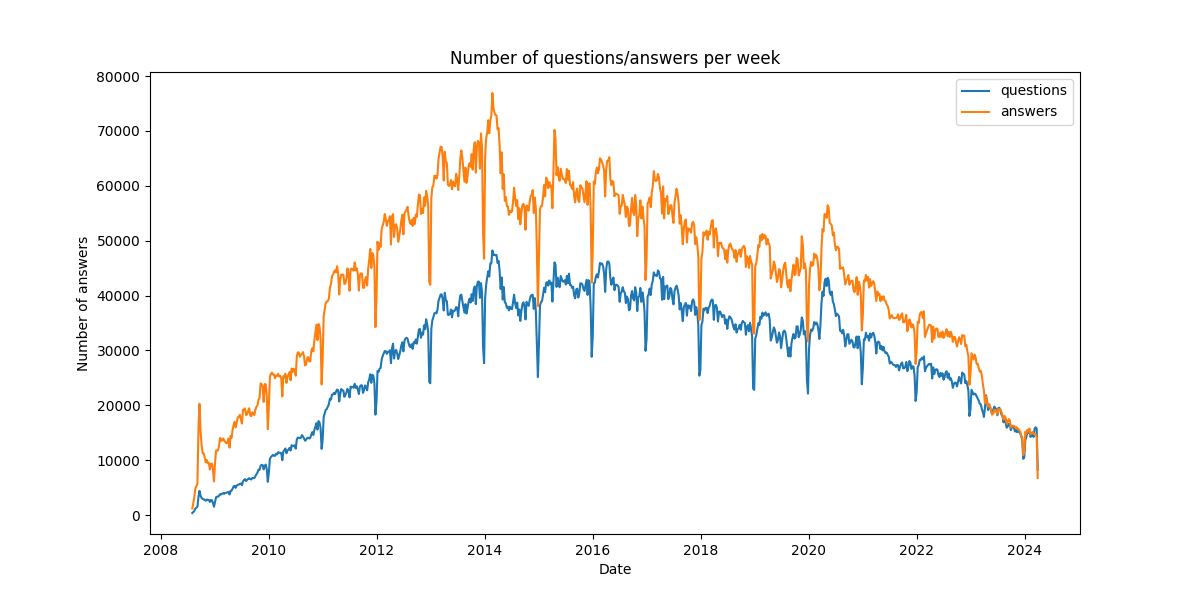

In [25]:
posts_grouped = (
    posts
    .filter(col('user_id').isNotNull())
    .groupBy(
        window('creation_date', '1 week')
    )
    .agg(
        sum(when(col('post_type_id') == 1, lit(1)).otherwise(lit(0))).alias('questions'),
        sum(when(col('post_type_id') == 2, lit(1)).otherwise(lit(0))).alias('answers')
    )
    .withColumn('date', col('window.start').cast('date'))
    .orderBy('date')
).toPandas()

posts_grouped.plot(
    x='date', 
    figsize=(12, 6), 
    title='Number of questions/answers per week',
    legend=True,
    xlabel='Date',
    ylabel='Number of answers',
    kind='line'
)
%matplot plt